In [1]:

import pandas as pd
import numpy as np
import ast
import gzip
import json
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# STEAM GAMES

### Primero cargo el dataframe

In [2]:
steam_games = pd.read_json('./datasets/steam_games.json.gz',compression='gzip',lines=True)

In [3]:
steam_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120445 entries, 0 to 120444
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   publisher     24083 non-null  object 
 1   genres        28852 non-null  object 
 2   app_name      32133 non-null  object 
 3   title         30085 non-null  object 
 4   url           32135 non-null  object 
 5   release_date  30068 non-null  object 
 6   tags          31972 non-null  object 
 7   reviews_url   32133 non-null  object 
 8   specs         31465 non-null  object 
 9   price         30758 non-null  object 
 10  early_access  32135 non-null  float64
 11  id            32133 non-null  float64
 12  developer     28836 non-null  object 
dtypes: float64(2), object(11)
memory usage: 11.9+ MB


In [4]:
steam_games.sample(10)

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,id,developer
27309,None,None,None,None,None,None,None,None,None,None,NaN,NaN,None
37364,None,None,None,None,None,None,None,None,None,None,NaN,NaN,None
14645,None,None,None,None,None,None,None,None,None,None,NaN,NaN,None
29472,None,None,None,None,None,None,None,None,None,None,NaN,NaN,None
20687,None,None,None,None,None,None,None,None,None,None,NaN,NaN,None
637,None,None,None,None,None,None,None,None,None,None,NaN,NaN,None
91036,None,"[Indie, RPG]",Fantasy Grounds - Maps: Graystone Castle,Fantasy Grounds - Maps: Graystone Castle,http://store.steampowered.com/app/328021/Fanta...,2014-10-10,"[RPG, Indie, Turn-Based, Fantasy, Sandbox, Onl...",http://steamcommunity.com/app/328021/reviews/?...,"[Multi-player, Co-op, Cross-Platform Multiplay...",4.99,0.0,328021.0,"SmiteWorks USA, LLC"
6747,None,None,None,None,None,None,None,None,None,None,NaN,NaN,None
73644,None,None,None,None,None,None,None,None,None,None,NaN,NaN,None
42884,None,None,None,None,None,None,None,None,None,None,NaN,NaN,None


### Elimino las filas completamente nulas

In [5]:

steam_games.dropna(how='all',inplace=True)

### Busco id nulos

In [6]:

steam_games[steam_games['id'].isnull()]

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,id,developer
88384,None,None,None,None,http://store.steampowered.com/,None,None,None,None,19.99,0.0,NaN,None
119271,"Warner Bros. Interactive Entertainment, Feral ...","[Action, Adventure]",Batman: Arkham City - Game of the Year Edition,Batman: Arkham City - Game of the Year Edition,http://store.steampowered.com/app/200260,2012-09-07,"[Action, Open World, Batman, Adventure, Stealt...",None,"[Single-player, Steam Achievements, Steam Trad...",19.99,0.0,NaN,"Rocksteady Studios,Feral Interactive (Mac)"


### Se encontraron dos filas con id nulo, una solo posee valores de url y precio, ademas el url es de la store de steam por lo tanto se eliminara.
### La otra fila con id nulo estaba replicada de otra fila, ya que tiene los mismos valores, por esto tambien se eliminara

In [7]:
steam_games[steam_games['title'] == 'Batman: Arkham City - Game of the Year Edition'] 

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,id,developer
89378,"Warner Bros. Interactive Entertainment, Feral ...","[Action, Adventure]",Batman: Arkham City - Game of the Year Edition,Batman: Arkham City - Game of the Year Edition,http://store.steampowered.com/app/200260/Batma...,2012-09-07,"[Action, Open World, Batman, Adventure, Stealt...",http://steamcommunity.com/app/200260/reviews/?...,"[Single-player, Steam Achievements, Steam Trad...",19.99,0.0,200260.0,"Rocksteady Studios,Feral Interactive (Mac)"
119271,"Warner Bros. Interactive Entertainment, Feral ...","[Action, Adventure]",Batman: Arkham City - Game of the Year Edition,Batman: Arkham City - Game of the Year Edition,http://store.steampowered.com/app/200260,2012-09-07,"[Action, Open World, Batman, Adventure, Stealt...",None,"[Single-player, Steam Achievements, Steam Trad...",19.99,0.0,NaN,"Rocksteady Studios,Feral Interactive (Mac)"


In [8]:
steam_games.dropna(subset=['id'],inplace=True) # Elimino las 2 filas con id nulo

### Busco los duplicados en id

In [9]:
duplicados = steam_games['id'].value_counts() > 1
steam_games[steam_games['id'].isin(duplicados[duplicados].index)]

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,id,developer
102204,Bethesda Softworks,[Action],Wolfenstein II: The New Colossus,Wolfenstein II: The New Colossus,http://store.steampowered.com/app/612880/,2017-10-26,"[Action, FPS, Gore, Violent, Alternate History...",http://steamcommunity.com/app/612880/reviews/?...,"[Single-player, Steam Achievements, Full contr...",59.99,0.0,612880.0,Machine Games
102883,Bethesda Softworks,[Action],Wolfenstein II: The New Colossus,Wolfenstein II: The New Colossus,http://store.steampowered.com/app/612880/Wolfe...,2017-10-26,"[Action, FPS, Gore, Violent, Alternate History...",http://steamcommunity.com/app/612880/reviews/?...,"[Single-player, Steam Achievements, Full contr...",59.99,0.0,612880.0,Machine Games


### Se encontraron dos filas completamente duplicadas se eliminara una

In [10]:
steam_games.drop_duplicates(subset='id',inplace=True,keep='first')

### Convierto el id a tipo entero

In [11]:
steam_games['id'] = steam_games['id'].astype('int') # Paso el id a entero

In [12]:
steam_games.isnull().sum()

publisher       8051
genres          3282
app_name           1
title           2049
url                0
release_date    2066
tags             162
reviews_url        0
specs            669
price           1377
early_access       0
id                 0
developer       3298
dtype: int64

In [13]:
steam_games[steam_games['app_name'].isnull()]

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,id,developer
90890,None,"[Action, Indie]",None,None,http://store.steampowered.com/app/317160/_/,2014-08-26,"[Action, Indie]",http://steamcommunity.com/app/317160/reviews/?...,"[Single-player, Game demo]",None,0.0,317160,None


### El unico juego que posee nulo en app_name y title, no pose ni desarrolador ni publicador, por esto se eliminara.

In [14]:
# El unico juego que no tiene ni titulo ni app_name tampoco tiene desarrollador o publicador, solo pose genero tag y un url que lleva a ningun juego, por esto se eliminara esta fila
steam_games.dropna(subset='app_name',inplace=True)

### Se remplazara los nulos de developer por los de publisher

In [15]:
steam_games['developer'].fillna(steam_games['publisher'],inplace=True)

### Se eliminaran las columnas que no seran usadas por el estudio.
* publisher
* title
* url
* discount_price
* reviews_url
* early_access
* specs


In [16]:
steam_proc = steam_games.drop(columns=['publisher','title','url','reviews_url','early_access','specs'])

### Veo que tags y genres son columnas con datos similares, por esto buscare los nulos en genres y en tags

In [17]:
steam_proc[steam_proc['genres'].isna()]

,genres,app_name,release_date,tags,price,id,developer
88314,None,Log Challenge,None,"[Action, Indie, Casual, Sports]",2.99,773570,None
88321,None,Icarus Six Sixty Six,None,[Casual],Free,724910,None
88329,None,After Life VR,None,"[Early Access, Indie, VR]",4.99,772590,None
88330,None,Kitty Hawk,None,"[Early Access, Action, Adventure, Indie, Casual]",2.99,640250,None
88332,None,Mortars VR,None,"[Early Access, Strategy, Action, Indie, Casual...",0.99,711440,None
...,...,...,...,...,...,...,...
120428,None,Robotpencil Presents: Exercise: Brushwork,2018-01-03,"[Design & Illustration, Tutorial]",3.99,775640,None
120429,None,Robotpencil Presents: Creative Composition,2018-01-03,"[Design & Illustration, Tutorial]",3.99,777930,None
120430,None,The Gamble House,2016-11-19,[Movie],4.99,775370,None
120431,None,Kalen Chock Presents: 2017 Free Tutorial,2018-01-03,"[Design & Illustration, Tutorial]",Free,777950,None


In [18]:
steam_proc[steam_proc['tags'].isna()]['genres']

88589             [Adventure]
88608     [Action, Adventure]
88619                [Casual]
88620                [Casual]
88668                    None
                 ...         
119935               [Casual]
119937           [Simulation]
119949                   None
119962                [Indie]
120118               [Casual]
Name: genres, Length: 162, dtype: object

### Ahora voy a eliminar los valores que no esten en alguna fila  de genres de la columna tag para tener solo los generos
### Luego voy a agregar valores de tag que no esten en genres 
### Luego voy a remplazar los nulos de genres con los valores de tags
### Por ultimo voy a eliminar la columna tags que ya no aporta informacion

In [19]:
genres = set(item for val in steam_proc['genres'].dropna() for item in val)# Obtengo los valores unicos de genres
 
steam_proc['tags'] = steam_proc['tags'].apply(lambda x: [item for item in x if item in genres] if isinstance(x, list) else x) # Los elimino de tags

steam_proc['genres'].fillna(steam_proc['tags'],inplace=True) # Remplazo los nulos de genres con los valores de tags


def agregar_genres_tags(fila): # Agrego valores de tangs en genres cuando estos no esten en genres.
    genres = fila['genres']
    tags = fila['tags']
    if isinstance(tags,list) and isinstance(genres,list):
        for tag in tags:
            if tag not in genres:
                genres.append(tag)
    return genres
steam_proc['genres'] = steam_proc.apply(lambda fila:agregar_genres_tags(fila),axis=1)


steam_proc.drop(columns=['tags'],inplace=True)




### Genero dummies para la columna genres,  y luego eliminare esta ultima

In [20]:

# Ahora voy a generar dummies para genres 
steam_proc['genres'] =  steam_proc['genres'].apply(lambda x:".".join(x) if isinstance(x, list) else x)
dummies = steam_proc['genres'].str.get_dummies(sep='.')
#dummies = dummies.groupby(dummies.columns, axis=1).sum()
steam_proc = pd.concat([steam_proc,dummies],axis=1)

# Elimino la columna genres
steam_proc.drop(columns='genres',inplace=True)


### Columna Price:
* Primero voy a poner en valor 0 los que tengan un str con Free

In [21]:

steam_proc.loc[steam_proc['price'].str.contains("Free", na=False), 'price'] = 0.0

* Reviso los valores de price y Free to Play


In [22]:
steam_proc.loc[steam_proc['price'].apply(lambda x: isinstance(x, str)), ['price','Free to Play']]

,price,Free to Play
90715,Install Now,1
91181,Play WARMACHINE: Tactics Demo,0
92142,Install Theme,0
92228,Third-party,0
92336,Play Now,0
111044,Play the Demo,0
113310,Starting at $499.00,0
113311,Starting at $449.00,0
114527,Play Now,0
120148,Third-party,1


* Remplazo los  valores que tenian un string y un precio por el precio asociado

In [23]:
# A los dos valores que incluye el precio como parte de un string lo remplazo con su valor de precio
steam_proc['price'].replace('Starting at $499.00',499.0,inplace=True)
steam_proc['price'].replace('Starting at $449.00',499.0,inplace=True)

* Cuando precio posee un string y Free to Play vale 1 remplazo por 0

In [24]:

steam_proc.loc[(steam_proc['Free to Play'] == 1) & steam_proc['price'].apply(lambda x: isinstance(x, str)), ['price']] = 0.0


* Veo los valores nulos de price donde Free to Play vale 1

In [25]:
steam_proc[pd.isna(steam_proc['price'])][['Free to Play']].value_counts()

Free to Play
0               1171
1                205
Name: count, dtype: int64

* A esos valores los remplazo por 1

In [26]:
steam_proc.loc[(steam_proc['Free to Play'] == 1) & (pd.isna(steam_proc['price'])), 'price'] = 0.0

* Veo la cantidad de nulos que quedaron en price respecto al total,y veo que no llega al 4% de nulos

In [27]:
steam_proc[steam_proc['price'].isnull()].shape[0]/steam_proc.shape[0]

0.03644455510254894

* Elimino el resto de nulos en price, al no poder realizarse mas un analisis , ya que no considero correcto remlplazar un precio por un premedio u otro valor

In [28]:
# Elimino los valores de precio donde sean nulos o donde o donde no sean de tipo string
steam_proc = steam_proc[steam_proc['price'].apply(lambda x: isinstance(x, float))]
steam_proc.dropna(subset='price',inplace=True)


* Tenindo normalizada esta columna la convierto a flaot

In [29]:
# Teniendo precio con formato numerico convierto la columna a float
steam_proc['price'] = steam_proc['price'].astype('float')

### Veo los nulos que aun quedaron

In [30]:
steam_proc.isnull().sum()

app_name                        0
release_date                 1952
price                           0
id                              0
developer                    3115
Accounting                      0
Action                          0
Adventure                       0
Animation &amp; Modeling        0
Audio Production                0
Casual                          0
Design &amp; Illustration       0
Early Access                    0
Education                       0
Free to Play                    0
Indie                           0
Massively Multiplayer           0
Photo Editing                   0
RPG                             0
Racing                          0
Simulation                      0
Software Training               0
Sports                          0
Strategy                        0
Utilities                       0
Video Production                0
Web Publishing                  0
dtype: int64

In [31]:
print(f'Porcentaje de nulos : {steam_proc.dropna(subset=["developer","release_date"]).shape[0] / steam_proc.shape[0]}')

Porcentaje de nulos : 0.8992052723396007


### Quedaron valores nulos en release_date, developer y specs que equivalen aproximadamente al 11% del dataframe. 
### Y al no poder hacer otro tratado se eliminaran

In [32]:
# Voy a liminar el resto de valores nulos
steam_proc.dropna(subset=['developer','release_date'],inplace=True)
steam_proc.isnull().sum()

app_name                     0
release_date                 0
price                        0
id                           0
developer                    0
Accounting                   0
Action                       0
Adventure                    0
Animation &amp; Modeling     0
Audio Production             0
Casual                       0
Design &amp; Illustration    0
Early Access                 0
Education                    0
Free to Play                 0
Indie                        0
Massively Multiplayer        0
Photo Editing                0
RPG                          0
Racing                       0
Simulation                   0
Software Training            0
Sports                       0
Strategy                     0
Utilities                    0
Video Production             0
Web Publishing               0
dtype: int64

### Convierto la columna release_date en datetime y genero la columna año

In [33]:
steam_proc['release_date'].value_counts()

release_date
2012-10-16    100
2017-08-31     90
2017-09-26     88
2017-07-25     78
2017-12-19     74
             ... 
2000-01-31      1
1994-08-15      1
1987-10-05      1
2021-12-31      1
2004-03-01      1
Name: count, Length: 3293, dtype: int64

In [34]:
# Conversion de tipos
steam_proc['release_date'] = pd.to_datetime(steam_proc['release_date'], errors='coerce')
steam_proc['release_date'].dropna(inplace=True)
# Genero una columna para el año
steam_proc['Year'] = steam_proc['release_date'].dt.year
steam_proc['Year'] = steam_proc['Year'].astype(float)

* Ahora la release_date no la usare por esto la eliminare

In [35]:
steam_proc.drop(columns=['release_date'],inplace=True)


### Por ultimo exporto como csv el proceso de ETL

In [ ]:
steam_proc.to_csv('./datasets/steam_games.csv',index=False)

# USERS REVIEWS

### Ahora voy a trabajar con el archivo user_reviews.json.gz, el cual guarda registros de los comentarios de los usuarios sobre distintos items


###  Primero realizo la carga

In [ ]:
user_reviews_gz = "./datasets/user_reviews.json.gz"
filas=[]
with gzip.open(user_reviews_gz, 'rt', encoding='MacRoman') as archivo:
    for line in archivo.readlines():
        filas.append(ast.literal_eval(line))

user_review = pd.DataFrame(filas)

In [ ]:
user_review

### Ahora veo que la columna reviews es una lista de diccionarios, donde cada item de la lista equivale a un producto distinto que ese usuario haya comendado, y cada cada diccionario guarda variables referentes al item y su posteo.
### Por esto primero voy a usar explode para duplicar las filas por cada item de la lista, y luego voy a generar un dataframe con el diccionario nuevo y lo concatenare a traves de las columnas con el el dataframe con filas duplicadas

In [ ]:
user_review_explode = user_review.explode('reviews') # Duplico las filas generando un diccionario por cada dicc#ionario en la lista
# Ahora concateno el dataframe original, con el dataframe generado a partir de transformar los diccionarios a pandas
user_review_explode = pd.concat([user_review_explode.drop(['reviews'],axis=1),user_review_explode['reviews'].apply(pd.Series)],axis=1)  

### Elimino columnas que no seran usadas para el estudio
* user_url
* funny
* last_edited
* helpful
* 0

In [ ]:
user_review_explode.drop(columns=['user_url','funny','helpful','last_edited',0],inplace=True)

In [ ]:
user_review_explode

### Ahora a partir de la columna reveiw se hara un analisis de sentimiento, generando una nueva columna.
### Este se llamara "sentiment_analysis"  y tendra 2 para sentimiento positivo 0 para negativo y 1 para neutral
### Habiendo hecho esto elimino la columna review

In [ ]:
#Hago el analisis de sentimiento en la columna review
nltk.download('vader_lexicon')
model_sentimiento = SentimentIntensityAnalyzer()


def analizador(review):
    # Obtener el puntaje de sentimiento usando SentimentIntensityAnalyzer
    sentimiento_score = model_sentimiento.polarity_scores(review)
    
    # Clasifico el sentimiento
    
    if review and not pd.isnull(review):
        if sentimiento_score['compound'] >= 0.05:
            return 2  # Sentimiento positivo
        elif sentimiento_score['compound'] <= -0.05:
            return 0  # Sentimiento negativo
        else:
            return 1  # Sentimiento neutral
    else:
        return 1

* Para aplicar la funcion los nulos tienen que ser vacio

In [ ]:
user_review_explode['review'].fillna('',inplace=True)

In [ ]:
user_review_explode['sentiment_analysis']  = user_review_explode['review'].apply(analizador)
user_review_explode.drop(columns='review',inplace=True)

* Grafico las el analisis por sentimiento de las reviews

In [ ]:
sns.histplot(data=user_review_explode,x='sentiment_analysis')

### Se buscan los nulos que quedaron

In [ ]:
user_review_explode.isnull().sum()

In [ ]:
user_review_explode[user_review_explode.isnull().any(axis=1)]

### Hay nulos pero coiciden con todas las columnas de reviews por esto se eliminaran

In [ ]:

user_review_explode.dropna(inplace=True)


In [ ]:
user_review_explode

### Por ultimo se exporta como csv

In [ ]:
user_review_explode.to_csv('./datasets/user_reviews.csv',index=False)

# Users Item

### Funcion para poder descomprimir el dataset de items

In [ ]:
def descompimir_json(ruta, variable_anidada):
    '''Función que recibe una ruta de acceso a un archivo json anidado y carga la información en un
    DataFrame de Pandas'''
    fila = []
    with gzip.open(ruta, 'rt', encoding='MacRoman') as archivo:
      for line in archivo.readlines():
          fila.append(ast.literal_eval(line))

    df = pd.DataFrame(fila)                                                 
    df = df.explode(variable_anidada).reset_index()                         
    df = df.drop(columns="index")                                           
    df = pd.concat([df, pd.json_normalize(df[variable_anidada])], axis=1)   
    df = df.drop(columns=variable_anidada)                                  

    return df

In [ ]:
user_items = descompimir_json("./datasets/users_items.json.gz",'items')

In [38]:
user_items.describe()

,items_count,steam_id,item_id,playtime_forever,playtime_2weeks
count,5.153209e+06,5.153209e+06,5.153209e+06,5.153209e+06,5.153209e+06
mean,3.147229e+02,7.656120e+16,1.784481e+05,9.914951e+02,9.104707e+00
std,6.933596e+02,3.916645e+07,1.318598e+05,5.418204e+03,1.403926e+02
min,1.000000e+00,7.656120e+16,1.000000e+01,0.000000e+00,0.000000e+00
25%,7.200000e+01,7.656120e+16,3.446000e+04,0.000000e+00,0.000000e+00
50%,1.380000e+02,7.656120e+16,2.144200e+05,3.400000e+01,0.000000e+00
75%,2.760000e+02,7.656120e+16,2.664300e+05,3.550000e+02,0.000000e+00
max,7.762000e+03,7.656120e+16,5.307200e+05,6.427730e+05,1.996700e+04


In [ ]:
user_items.isnull().sum()

In [ ]:
user_items[user_items['item_id'].isna()]

## Todos los nulos hacen referencia a las mismas filas por esto seran eliminados

In [ ]:
user_items.dropna(inplace=True)

### Por ultimo elimino las columnas que no usare

In [ ]:
user_items.drop(columns=['user_url','playtime_2weeks','steam_id'])

<Axes: ylabel='playtime_forever'>

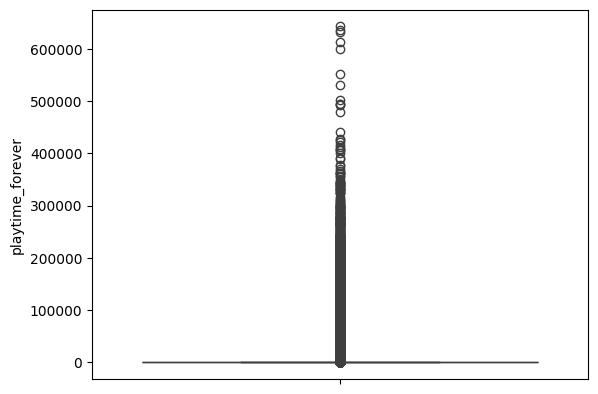

In [37]:
sns.boxplot(data=user_items,y='playtime_forever') # Hago un diagrama de caja para ver outliers

### Tiene muchos outliers, pero si se consideran minutos no tienen que ser necesariamente errores

### Exporto el dataframe a csv y lo comprimo en gz


In [ ]:
user_items.to_csv('./datasets/users_item_proc.csv',index=False)

In [ ]:
with gzip.open('user_items_proc.csv.gz', 'wb') as f:
    user_items.to_csv(f, index=False, encoding='utf-8')